Average difference of 0.007581 with std. dev. of 0.007833.


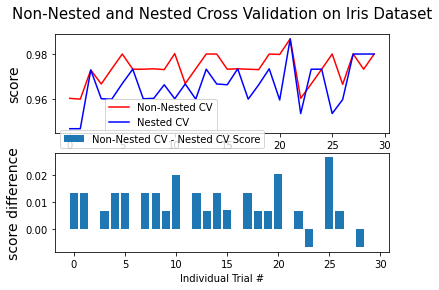

In [12]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate
import numpy as np

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

In [19]:
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf1 = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_validate(clf1, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score['test_score'].mean()

score_difference = non_nested_scores - nested_scores

In [20]:
nested_scores

array([0.94683499, 0.94683499, 0.97297297, 0.9601707 , 0.95999289,
       0.96692745, 0.97332859, 0.9601707 , 0.96034851, 0.96639403,
       0.9601707 , 0.96674964, 0.95999289, 0.97332859, 0.96674964,
       0.96639403, 0.9735064 , 0.95999289, 0.96639403, 0.9735064 ,
       0.95963727, 0.98684211, 0.95359175, 0.97332859, 0.97332859,
       0.95359175, 0.95981508, 0.98008535, 0.98008535, 0.98008535])

In [10]:
len(nested_scores)

30

In [23]:
clf.best_params_

{'C': 10, 'gamma': 0.1}

In [22]:
clf1.best

GridSearchCV(cv=KFold(n_splits=4, random_state=29, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.1]})

In [24]:
from nested_cv import NestedCV

import pandas as pd
import numpy as np
from sklearn.datasets import load_boston, load_iris, load_breast_cancer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold

# When using Random Search, we get a user warning with this little number of hyperparameters
# Suppress it
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [35]:
boston = load_boston()
X = boston.data
y = boston.target

# Define a parameters grid
param_grid = {
     'max_depth': [3, 7],
     'n_estimators': [100,200],
     'min_samples_split':[2,3,5]
}

# Either specify a strategy or number
# Here we choose a strategy
outer_cv = KFold(n_splits=5,
                 shuffle=True,
                 random_state=123)
inner_cv = KFold(n_splits=5,
                 shuffle=True,
                 random_state=123)

NCV = NestedCV(model=RandomForestRegressor(), params_grid=param_grid,
               outer_kfolds=5, inner_kfolds=2, n_jobs = -1,
               cv_options={'sqrt_of_score':True, 
                           'recursive_feature_elimination':False, 
                           'rfe_n_features':2})
NCV.fit(X=X,y=y)

NCV.outer_scores

[2.860473608014735,
 3.577895154701892,
 3.603666350529373,
 3.088446559952187,
 3.5832077076182833]

In [36]:
NCV.best_params

{'max_depth': [7], 'min_samples_split': [3, 2, 5], 'n_estimators': [200, 100]}

In [37]:
NCV.best_inner_params_list

[{'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 200},
 {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100},
 {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200},
 {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100},
 {'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 100}]

In [34]:
NCV.best_inner_score_list

[2.2716089820372356,
 2.7655884396154735,
 3.0602826445350324,
 3.0722791950906236,
 2.7552906915242987]